In [1]:
# imports
import scipy
import numpy as np
from matplotlib import pyplot as plt
import batman
from scipy.optimize import curve_fit

In [2]:
# extract photometry data
fname = "diffphoto1.xls"
with open(fname, 'r') as file:
    lines = file.readlines()
    lines = [i.strip('\n') for i in lines]
    lines = [i.split() for i in lines]

In [3]:
# get JD-2400000 time, normalize flux to out-of-transit median
t = np.array([float(i[3]) for i in lines[1:]])
flux = np.array([float(i[15]) for i in lines[1:]])
fluxerror = np.array([float(i[25]) for i in lines[1:]])
out_of_transit_list = np.append(flux[:80], flux[-80:])
flux = flux / np.median(out_of_transit_list)
fluxerror = fluxerror / np.median(out_of_transit_list)

In [4]:
# batman model from planetary parameters
def func(t, t0, rp, a, inc):
    params = batman.TransitParams()
    params.t0 = t0 #59636.861541          #time of inferior conjunction
    params.per = 1.729257                 #period
    params.rp = rp #0.139589              #planet radius (in units of stellar radii)
    params.a = a #8.02                    #semi-major axis (in units of stellar radii)
    params.inc = inc #87.75               #orbital inclination (in degrees)
    params.ecc = 0                        #eccentricity
    params.w = 90                         #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [0.53782286, 0.19482178]   #quadratic limb darkening coefficients
    
    m = batman.TransitModel(params, np.array(t))
    f = m.light_curve(params)
    return f

<Figure size 432x288 with 0 Axes>

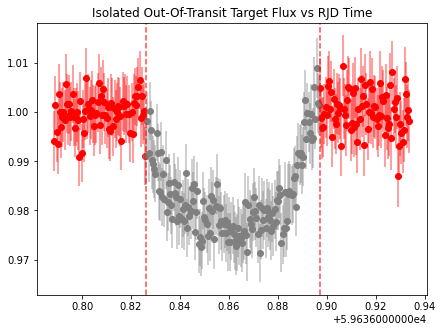

In [5]:
# list of parameters with exoplanet archive data, plots model from guess
plt.clf()
paramlist = ['t0', 'r_planet/r_star', 'semimajor_axis/r_star', 'inclination']
init = [59636.861541, 0.139589, 8.02, 87.75]
model_guess = func(t, *init)

plt.figure(figsize=(7, 5))
plt.title("Isolated Out-Of-Transit Target Flux vs RJD Time")

plt.scatter(t[:80], flux[:80], color='red')
plt.scatter(t[80:-80], flux[80:-80], color='grey')
plt.scatter(t[-80:], flux[-80:], color='red')


plt.errorbar(t[:80], flux[:80], yerr=fluxerror[:80], fmt='.', color='red', alpha=0.5)
plt.errorbar(t[80:-80], flux[80:-80], yerr=fluxerror[80:-80], fmt='.', color='grey', alpha=0.5)
plt.errorbar(t[-80:], flux[-80:], yerr=fluxerror[-80:], fmt='.', color='red', alpha=0.5)


# plt.plot(t, model_guess, lw=2, color='navy')

plt.axvline(t[80], ls='--', color='red', alpha=0.7)
plt.axvline(t[-80], ls='--', color='red', alpha=0.7)

plt.savefig('plt2.png', dpi=1000)

In [6]:
# fits model to 4 system parameters
popt, pcov = curve_fit(func, t, flux, p0=init, sigma=fluxerror)
error = [((popt[i]-val)/val)*100 for i, val in enumerate(init)]
max_length = np.max(np.array([len(i) for i in paramlist]))

for i in range(len(init)):
    spacing_param = max_length - len(paramlist[i])
    print(paramlist[i], 'Known:    ' + ' '*spacing_param , init[i])
    print(paramlist[i], 'Fitted:   ' + ' '*spacing_param, popt[i])
    print(paramlist[i], '% Error:  ' + ' '*spacing_param, error[i])

t0 Known:                        59636.861541
t0 Fitted:                       59636.859601099946
t0 % Error:                      -3.252854026799792e-06
r_planet/r_star Known:           0.139589
r_planet/r_star Fitted:          0.1386323174401583
r_planet/r_star % Error:         -0.6853566970475377
semimajor_axis/r_star Known:     8.02
semimajor_axis/r_star Fitted:    8.02415629343442
semimajor_axis/r_star % Error:   0.05182410766109629
inclination Known:               87.75
inclination Fitted:              86.97470403522962
inclination % Error:             -0.8835281649804889


Text(0.5, 1.0, 'Final Fitted Model Overplot')

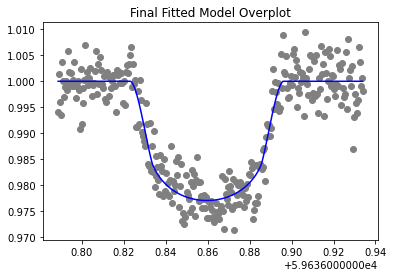

In [7]:
# final plot
# plt.title("Model Overplot from Initial Guess Parameters")
plt.scatter(t, flux, color='grey')
plt.plot(t, func(t, *popt), color='blue')
# plt.plot(t, model_guess)
plt.title("Final Fitted Model Overplot")

In [8]:
residuals = flux - func(t, *popt)

7.872008275833124e-05


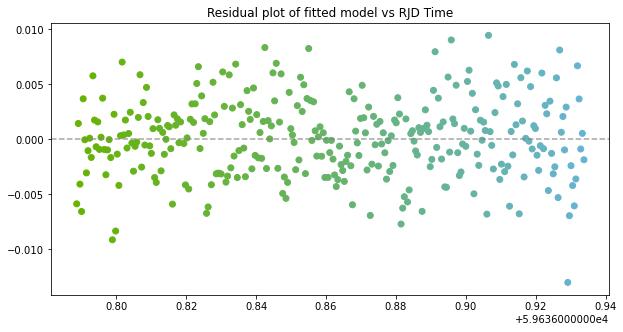

In [9]:
plt.figure(figsize=(10, 5))
cs = [(0.4, .7, (i)/(1.2*len(t))) for i in range(len(t))]
plt.scatter(t, residuals, color=cs)
plt.axhline(0, ls='--', color='grey', alpha=0.7)
plt.title("Residual plot of fitted model vs RJD Time")
print(np.mean(residuals))
# plt.savefig("plt4.png", dpi=1000)

7.872008275833124e-05
0.0035438244088629497
[0.00602504 0.0061103  0.00608188 0.00608188]
0.006038794013587751


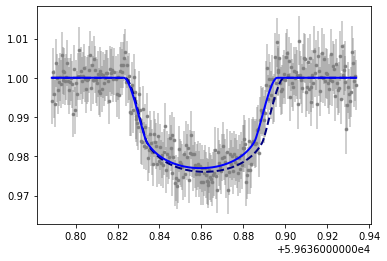

In [10]:
# normalerror = fluxerror / np.median(fluxerror) * np.std(residuals)
plt.errorbar(t, flux, yerr=fluxerror, fmt='.', color='grey', alpha=0.5, zorder=1)
plt.scatter(t, flux, color='grey', s=4, zorder=2)
plt.plot(t, model_guess, lw=2, ls='--', color='navy', zorder=3)
plt.plot(t, func(t, *popt), color='blue', lw=2, zorder=4)

print(np.mean(residuals))
print(np.std(residuals))
print(fluxerror[1:5])
print(np.mean(fluxerror))

313


<Figure size 432x288 with 0 Axes>

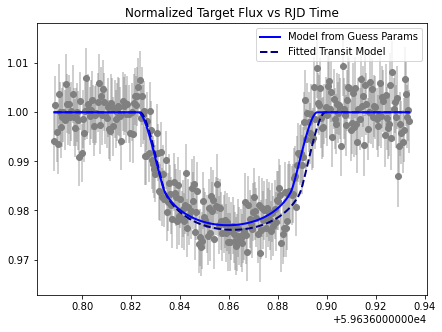

In [11]:
plt.clf()
plt.figure(figsize=(7, 5))
plt.title("Normalized Target Flux vs RJD Time")
plt.errorbar(t, flux, yerr=fluxerror, fmt='.', color='grey', alpha=0.5, zorder=1)
print(len(t))
# cs = [((i+.2)/(len(t)), .5, (i+.2)/(3*len(t))) for i in range(len(t))]
plt.scatter(t, flux, c='grey', zorder=2)
test2 = plt.plot(t, func(t, *popt), color="blue", lw=2, zorder=4, label="Model from Guess Params")
test1 = plt.plot(t, model_guess, lw=2, ls='--', color='navy', zorder=3, label="Fitted Transit Model")

plt.legend(loc="upper right")
plt.savefig("plt3.png", dpi=1000)

<Figure size 432x288 with 0 Axes>

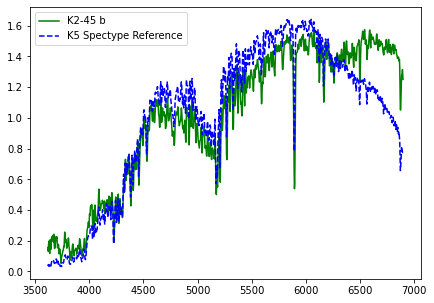

In [13]:
from astropy.io import fits
plt.clf()
plt.figure(figsize=(7, 5))
hdu = fits.open('spec_k245_fluxcal.fits')

spectrum = hdu[0].data
header = hdu[0].header
wavestart = header['CRVAL1']
dispersion = header['CD1_1']

wavelength = dispersion*np.arange(spectrum.shape[0])+wavestart
spectrum /= np.mean(spectrum)
plt.plot(wavelength, spectrum, color='green', label="K2-45 b")


hdu2 = fits.open('K5V.rawinstr.fits')
spectrum2 = hdu2[0].data
header2 = hdu2[0].header
wavestart2 = header['CRVAL1']
dispersion2 = header['CD1_1']

wavelength2 = dispersion2*np.arange(spectrum2.shape[0])+wavestart2
spectrum2 /= np.mean(spectrum2)

plt.plot(wavelength2, spectrum2, ls='--', color='blue', label="K5 Spectype Reference")
plt.legend()

plt.savefig("plt6.jpg", dpi=1000)
plt.show()
